# 実験概要
## CMNによる特徴量抽出
**ケプストラム平均正規化** (Cepstrum Mean Normalization : CMN) を使用し、特徴量を抽出する。
切り出した波形に対して**離散フーリエ変換** (Discrete Fourier Transform : DFT) を行い、絶対値を取ることで**振幅スペクトル**を得る。
これに対して対数を取って**対数振幅スペクトル**に変換し、逆離散フーリエ変換 (Inverse Discrete Fourier Transform : IDFT) を行うことで、ケプストラム領域へと変換し、先頭50要素を切り出し、結合した100要素の配列を前処理として返す。
この前処理は
```
left, right, posture = pp.slicer("raw\\" + tester.**.**.value)
cepstrum = pp.cmn_denoise(left, right)
```
によって行われる。

## DNNによる寝姿勢分類
本実験ではResNetを用いたHAR(Human Activities Recognition)を用いて学習と推論を行う。

# DataLoaderの定義

In [20]:
import torch
from typing import Tuple
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np

# 自作モジュール
import utills.datapath as dpath
import utills.preprocess as pp
import utills.record_utillities as ru

class dataset(Dataset):
    def __init__(self, paths, concat=True, transforms=None):
        self.transforms = transforms
        self.concat = concat

        # データを格納する配列を確保
        if concat:
            self.train_cepstrum = np.empty((0, 100))  # 100要素の配列
        else:
            self.train_cepstrum = []
        self.train_posture = np.empty(0)  # 姿勢データ配列

        # データ読み込みと前処理
        for p in paths:
            left, right, posture = pp.slicer(p)
            cepstrum = pp.cmn_denoise(left, right, concat=concat, breathcut="simple")
            # cepstrum = pp.fit_deconv(left, right, concat=concat)
            for cep in cepstrum:
                if concat:
                    self.train_cepstrum = np.vstack((self.train_cepstrum, cep)) if self.train_cepstrum.size else cep
                else:
                    self.train_cepstrum.append(cep)
            self.train_posture = np.append(self.train_posture, posture) if self.train_posture.size else posture

    def __len__(self):
        return len(self.train_posture)

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        if self.concat:
            cepstrum = torch.tensor(self.train_cepstrum[idx].reshape(1,-1), dtype=torch.float32)
        else:
            cepstrum = torch.tensor(self.train_cepstrum[idx], dtype=torch.float32)
        posture = torch.tensor(self.train_posture[idx]-1, dtype=torch.long)
        if self.transforms is not None:
            cepstrum = self.transforms(cepstrum)
            posture = self.transforms(posture)
        return cepstrum, posture

# 学習＆検証

In [21]:
import torch
import random
import os
import warnings

def seed_everything(seed=0):
    random.seed(seed)  # Python標準のrandomモジュールのシードを設定
    os.environ['PYTHONHASHSEED'] = str(seed)  # ハッシュ生成のためのシードを環境変数に設定
    np.random.seed(seed)  # NumPyの乱数生成器のシードを設定
    torch.manual_seed(seed)  # PyTorchの乱数生成器のシードをCPU用に設定
    torch.cuda.manual_seed(seed)  # PyTorchの乱数生成器のシードをGPU用に設定
    torch.backends.cudnn.deterministic = True  # PyTorchの畳み込み演算の再現性を確保

seed_everything()  # 上述のシード設定関数を呼び出し

warnings.simplefilter('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
# 被験者
identity = dpath.LMH.L001.value.fl_center
batch_size = 128
# データの形
concat = False

# 訓練データのパスを取得
train_type, train_tester, train_mattress, train_position = dpath.getattributes(identity)
val_tester = 'M004'
train_paths = []
for mat in dpath.mattress_all():
    if mat == train_mattress:
        continue
        # pass
    train_paths.extend(eval(f"dpath.LMH.search('{mat}', skip=[dpath.{train_type}.{train_tester}])"))
train_paths.extend(eval(f"dpath.YMGT.search('ka', skip=[dpath.{train_type}.{train_tester}])") if train_type=='YMGT' else dpath.YMGT.search('ka'))
train_paths.extend(eval(f"dpath.YMGT2023.search('Air', skip=[dpath.{train_type}.{train_tester}])") if train_type == 'YMGT2023' else dpath.YMGT2023.search('Air'))
train_paths = dpath.filter(train_paths, val_tester)

# 検証データのパスを取得
validation_paths = eval(f"dpath.LMH.{val_tester}.value.all()")
for i in range(len(validation_paths)):
    validation_paths[i] = validation_paths[i].value
validation_paths = dpath.filter(validation_paths, train_mattress)
    
# テストデータのパスを取得
test_path = [identity.value]

gif_dir = f"..//images//{train_type}_{train_tester}//{train_mattress}_{train_position}"    # gifファイルの保存場所

print("--- train ---")
train = dataset(train_paths, concat=concat)
print("--- validation ---")
val = dataset(validation_paths, concat=concat)
print("--- test ---")
test = dataset(test_path, concat=concat)

train_loader = DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True,
    drop_last = True
)

val_loader = DataLoader(
    val,
    batch_size=batch_size,
    shuffle=True,
    drop_last = True
)

test_loader = DataLoader(
    test,
    shuffle=False,
)

--- train ---
raw\YMGT\YMGT_5\ka_center | data[179 / 341]
raw\LMH\M001\ka_left | data[204 / 301]
raw\LMH\H003\ka_right | data[218 / 238]
raw\LMH\H002\ka_left | data[154 / 223]
raw\YMGT_2023\YMGT_5\Air_right | data[176 / 208]
raw\LMH\L003\ka_left | data[209 / 253]
raw\YMGT_2023\YMGT_1\Air_left | data[197 / 238]
raw\YMGT\YMGT_5\ka_left | data[227 / 337]
raw\YMGT\YMGT_6\ka_left | data[219 / 388]
raw\YMGT_2023\YMGT_6\Air_center | data[198 / 223]
raw\YMGT\YMGT_9\ka_center | data[291 / 411]
raw\LMH\M003\ka_left | data[230 / 399]
raw\YMGT\YMGT_2\ka_left | data[167 / 187]
raw\YMGT_2023\YMGT_2\Air_center | data[210 / 220]
raw\LMH\H003\ka_center | data[204 / 215]
raw\YMGT\YMGT_9\ka_left | data[320 / 418]
raw\LMH\M002\ka_center | data[277 / 594]
raw\YMGT_2023\YMGT_11\Air_left | data[205 / 242]
raw\LMH\M001\ka_center | data[171 / 356]
raw\YMGT_2023\YMGT_8\Air_right | data[196 / 253]
raw\YMGT_2023\YMGT_7\Air_center | data[185 / 223]
raw\LMH\H003\ka_left | data[193 / 215]
raw\YMGT\YMGT_7\ka_right | 

## gradcamの動作定義

In [23]:
from model import gradcam
import matplotlib.pyplot as plt

def visualize_gradcam(gc : gradcam.GradCAM1D,
                      TorF_flag=None,
                      save_path=None,
                      show=False,    
                      msg=None  ):
    # ディレクトリの属性を取得
    if save_path is not None:
        dir_name = os.path.dirname(save_path)
        gif_name = os.path.basename(save_path)

    # クラスごとのヒートマップを保持
    result_cam = [np.empty((0, pp.quef_high_cutoff)) for _ in range(4)]
    left_cep = np.empty((0, pp.quef_high_cutoff))
    right_cep = np.empty((0, pp.quef_high_cutoff))

    # 推論ループ
    for input, label in test_loader:
        input = input.to(device).detach()
        label = label.to(device).detach()

        # ヒートマップ生成（形状: (1, 50) を仮定）
        cam, _ = gc.generate(input, size=pp.quef_high_cutoff-pp.quef_low_cutoff)
        cam_np = cam.cpu().numpy()[0]

        target_class = label.item()  # クラスIDをintで取得
        # vstack で縦に積む（1行追加）
        result_cam[target_class] = np.vstack((result_cam[target_class], cam_np))
        left_cep = np.vstack((left_cep, input[0, 0].cpu().numpy()))
        right_cep = np.vstack((right_cep, input[0, 1].cpu().numpy()))

    # 各クラスの shape を表示
    """
    for class_id, cams in enumerate(result_cam):
        print(f"Class {class_id}: shape = {cams.shape}")
    """
    print("GradCam_generated!!")

    # 全クラスのヒートマップをまとめて結合（縦方向）
    all_cams = np.vstack(result_cam)
    all_cams, left_cep, right_cep = np.rot90(all_cams), np.rot90(left_cep), np.rot90(right_cep)

    # grad-camの結果をヒートマップに表示
    def plot_gradcam(cepstrums, title="GradCAM Heatmap"):
        plt.figure(figsize=(10, 6), facecolor='none')
        plt.imshow(cepstrums, aspect='auto', cmap='gray', interpolation='none')
        plt.imshow(all_cams, aspect='auto', cmap='jet', interpolation='antialiased', alpha=0.3)
        # 正解箇所に赤点をプロット
        if TorF_flag is not None:
            for i in range(len(TorF_flag)):
                if TorF_flag[i]:
                    plt.plot(i, pp.quef_high_cutoff-1, marker='.', color='red', markersize=4)
        plt.colorbar()
        plt.title(title)
        plt.xlabel("Time step")
        plt.ylabel("Sample")
        # メッセージを表示
        if msg is not None:
            plt.text(5, 3, msg, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.65))
        # 画像の保存
        if save_path is not None:
            # saveディレクトリが存在しなければFalse
            if os.path.exists(dir_name) == False:
                os.makedirs(dir_name)
                os.chmod(dir_name, 777)
            plt.savefig(save_path, transparent=False, facecolor='white')
        if show:
            plt.show()

    plot_gradcam(left_cep, title="GradCAM Heatmap (left)")
    # plot_gradcam(right_cep, title="GradCAM Heatmap (right)")


def visualize_gradcam2(gc : gradcam.GradCAM1D,
                       title=None):
    # 結果を格納する配列
    result_cam = [np.empty((0, pp.quef_high_cutoff)) for _ in range(4)]     # クラスごとのヒートマップを保持
    correct_cam = [np.empty((0, pp.quef_high_cutoff)) for _ in range(4)]
    incorrect_cam = [np.empty((0, pp.quef_high_cutoff)) for _ in range(4)]

    # 精度を求めるための配列
    num_of_that_class = np.zeros(4)
    correct_of_that_class = np.zeros(4)

    # 推論ループ
    for input, label in test_loader:
        input = input.to(device).detach()
        label = label.to(device).detach()

        # ヒートマップ生成（形状: (1, 50) を仮定）
        cam, pred = gc.generate(input, size=pp.quef_high_cutoff-pp.quef_low_cutoff)
        cam_np = cam.cpu().numpy()[0]

        target_class = label.item()  # クラスIDをintで取得
        # vstack で縦に積む（1行追加）
        result_cam[target_class] = np.vstack((result_cam[target_class], cam_np))
        num_of_that_class[target_class] += 1
        if target_class == pred:
            correct_of_that_class[target_class] += 1
            correct_cam[target_class] = np.vstack((correct_cam[target_class], cam_np))
        else:
            incorrect_cam[target_class] = np.vstack((incorrect_cam[target_class], cam_np))

    # プロット
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    x = np.linspace(0, pp.quef_high_cutoff-pp.quef_low_cutoff)
    for i, ax in enumerate(axes):
        acc = (correct_of_that_class[i]/num_of_that_class[i]) * 100     # クラスごとの精度
        if len(correct_cam) != 0:       # 正解データがあれば描画する
            ax.plot(x, np.mean(correct_cam[i], axis=0), label="correct", color='red')
        if len(incorrect_cam) != 0:     # 不正解データがあれば描画する
            ax.plot(x, np.mean(incorrect_cam[i], axis=0), label="incorrect", color='blue')
        if acc >= 50:
            color = 'red'
        else:
            color = 'blue'
        ax.set_title(f"class {i}: acc {acc:.2f}%", fontsize=14 ,color=color)
        ax.legend(fontsize=14)
        ax.set_xlabel("Cepstrum", fontsize=12)
        ax.set_ylabel("Grad-CAM", fontsize=12)

    # 図全体のタイトル
    plt.suptitle(title, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.98])  # suptitle用に余白を追加
    plt.show()

## 学習

### ResNetによる学習

loss : 1.44763, acc : 0.23392
Epoch[1/100] | train_loss: 1.38282 | train_acc: 0.29127 | val_loss: 1.32245 | val_acc: 0.40625
GradCam_generated!!
loss : 1.43430, acc : 0.14620
Epoch[2/100] | train_loss: 1.33125 | train_acc: 0.35660 | val_loss: 1.24510 | val_acc: 0.45469
GradCam_generated!!
loss : 1.30944, acc : 0.28070
Epoch[3/100] | train_loss: 1.27409 | train_acc: 0.41774 | val_loss: 1.12238 | val_acc: 0.54375
GradCam_generated!!
loss : 1.18428, acc : 0.50292
Epoch[4/100] | train_loss: 1.19491 | train_acc: 0.47328 | val_loss: 0.95999 | val_acc: 0.62969
GradCam_generated!!
loss : 1.09935, acc : 0.50292
Epoch[5/100] | train_loss: 1.12246 | train_acc: 0.51268 | val_loss: 0.89369 | val_acc: 0.63906
GradCam_generated!!
loss : 1.07053, acc : 0.50877
Epoch[6/100] | train_loss: 1.05832 | train_acc: 0.54461 | val_loss: 0.83132 | val_acc: 0.66094
GradCam_generated!!
loss : 1.05710, acc : 0.49708
Epoch[7/100] | train_loss: 1.01347 | train_acc: 0.56760 | val_loss: 0.78737 | val_acc: 0.65938
GradC

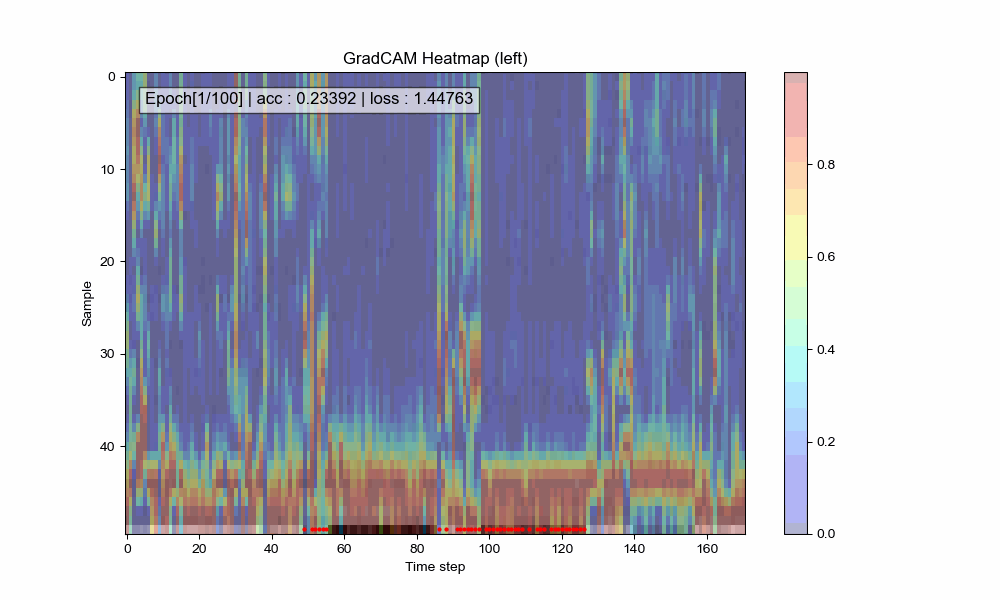

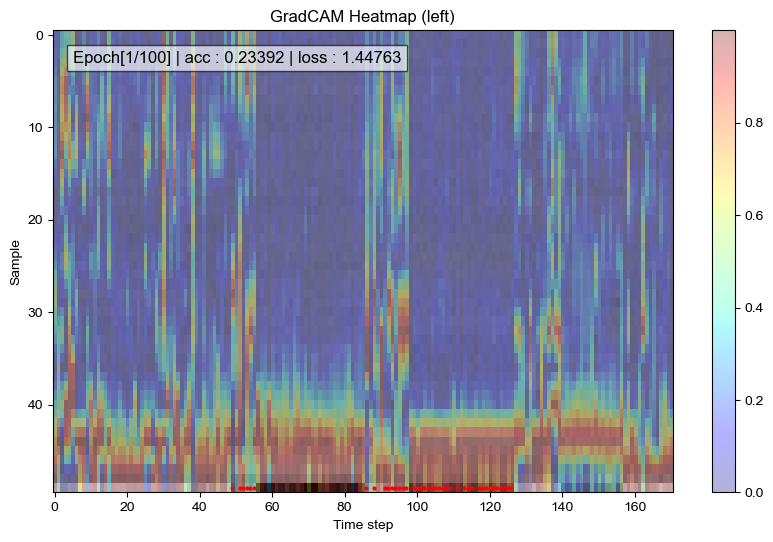

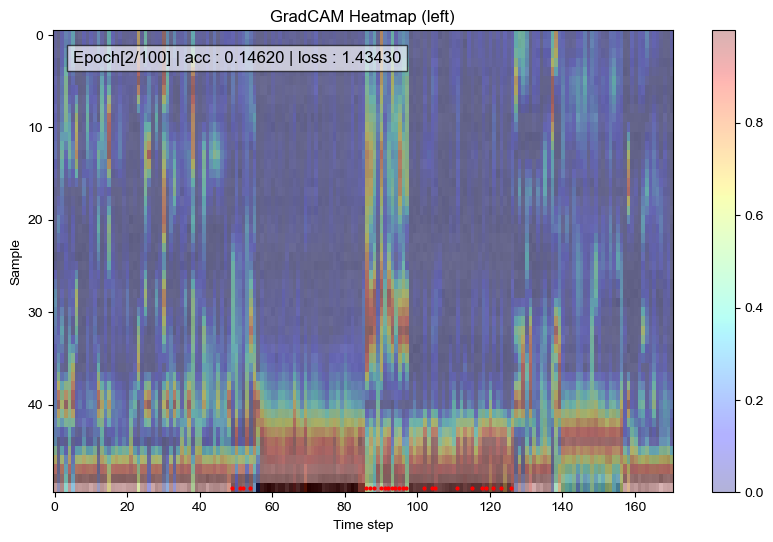

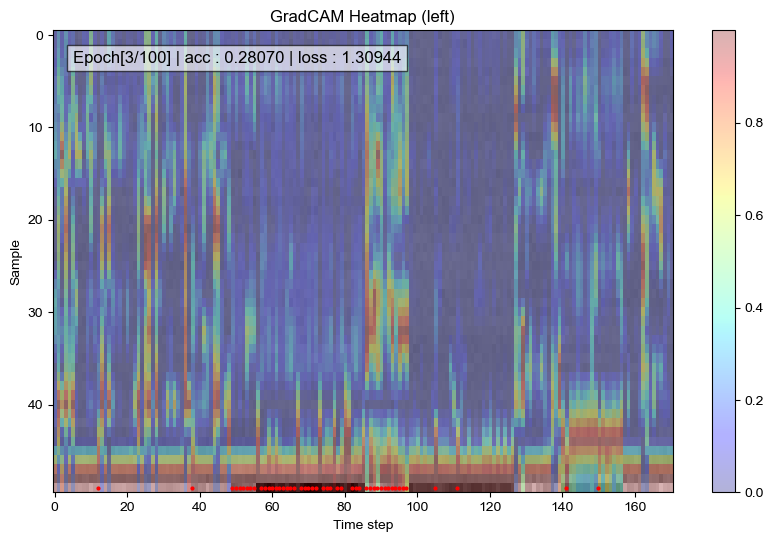

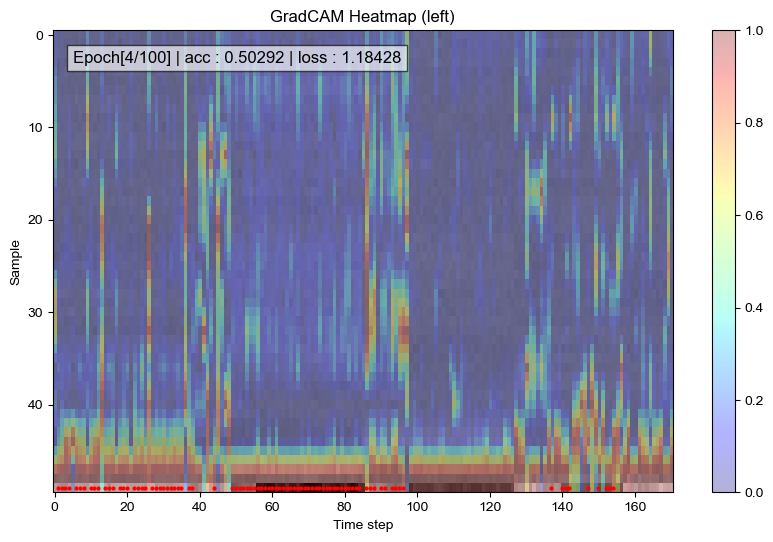

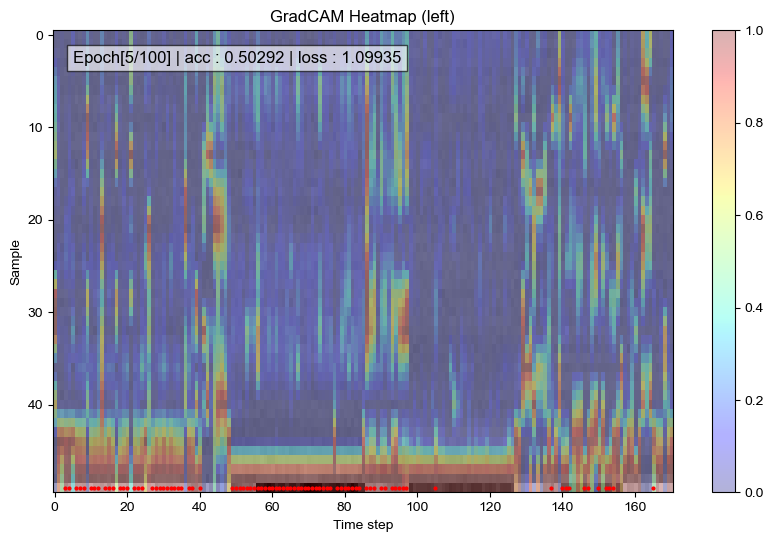

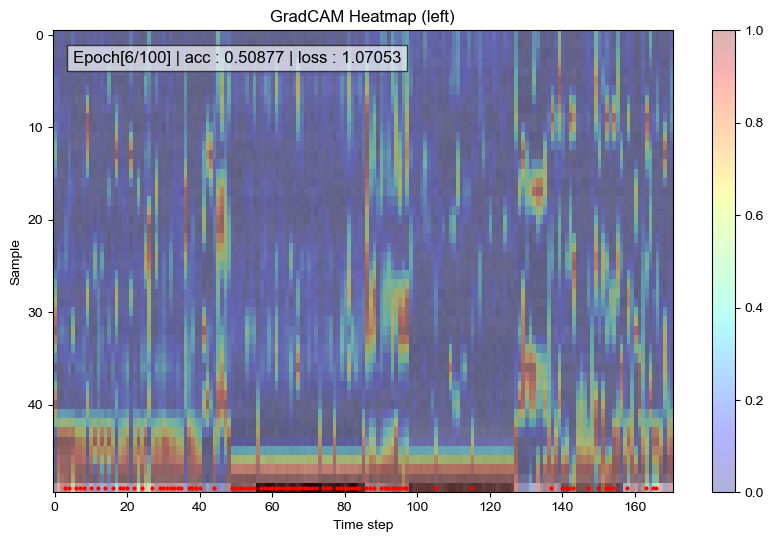

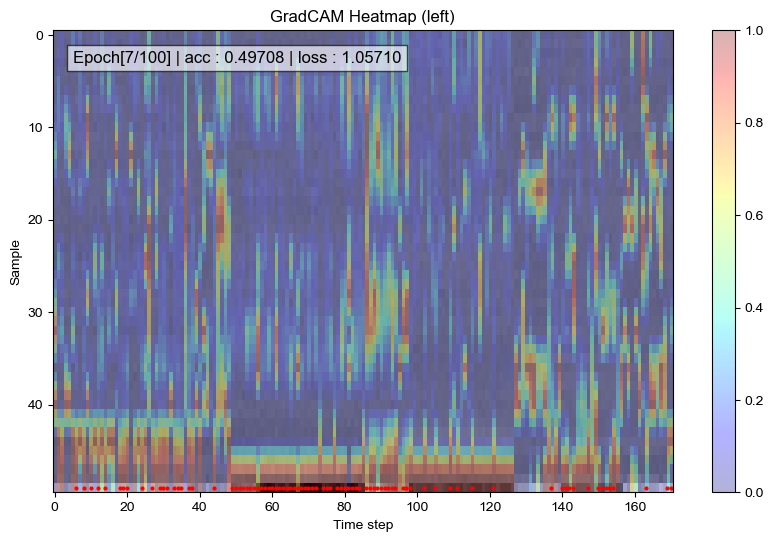

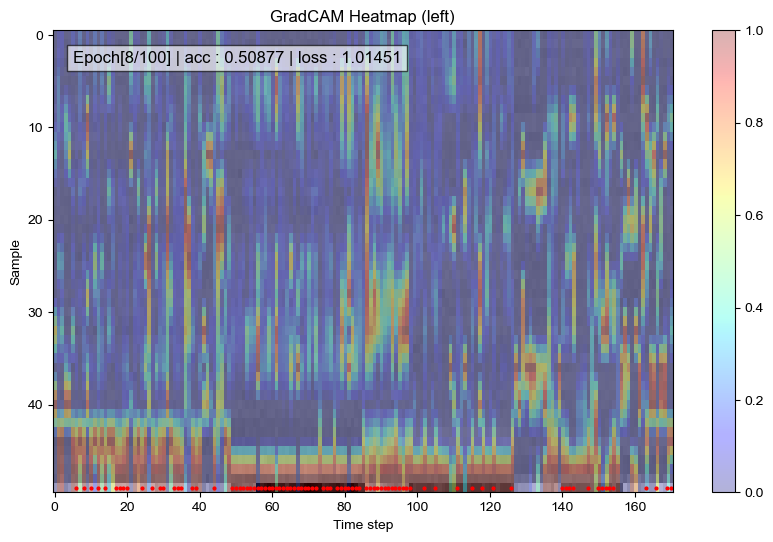

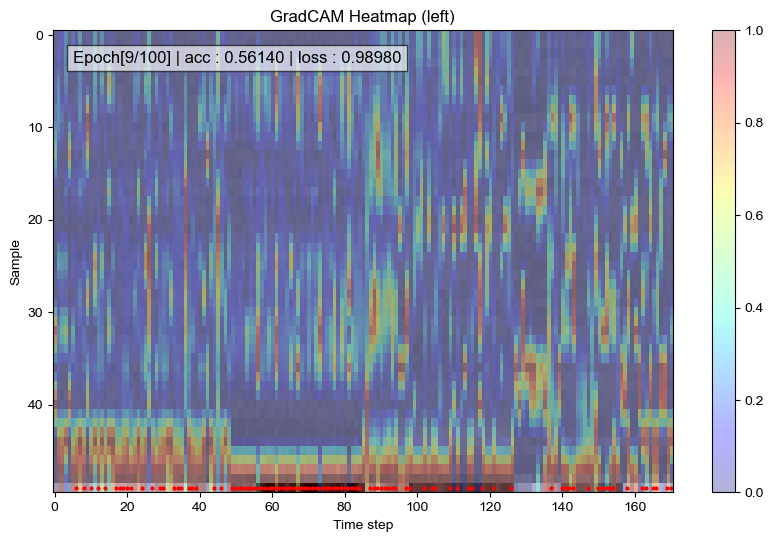

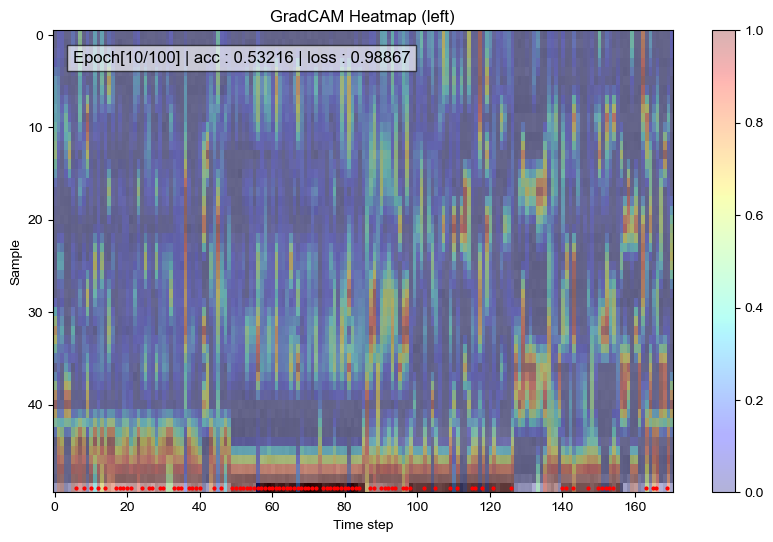

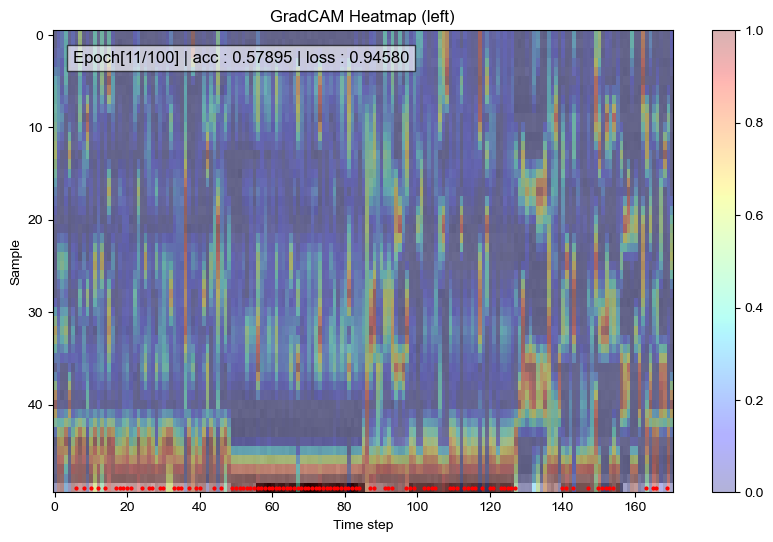

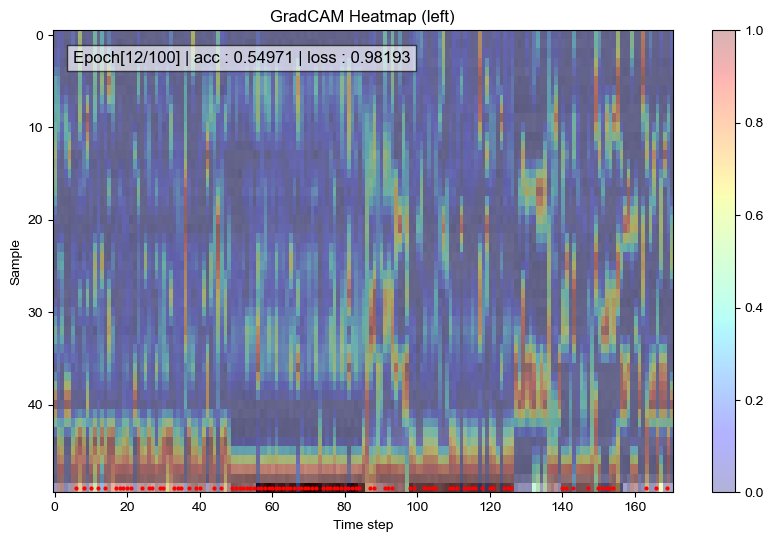

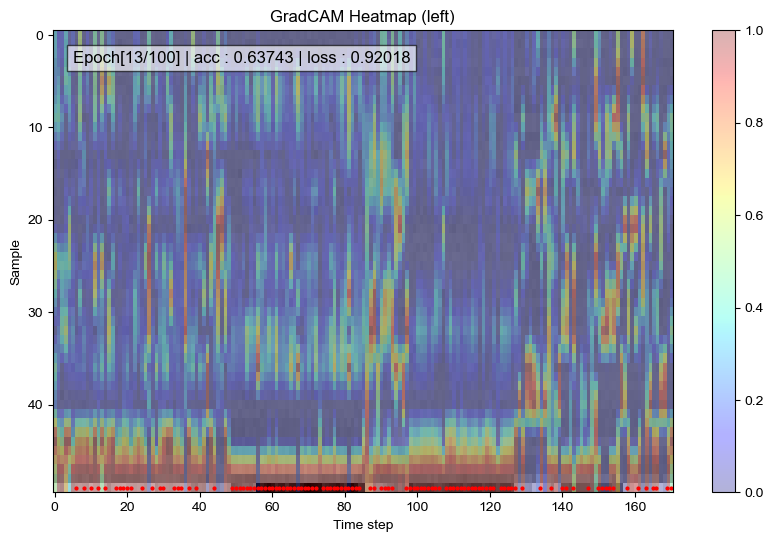

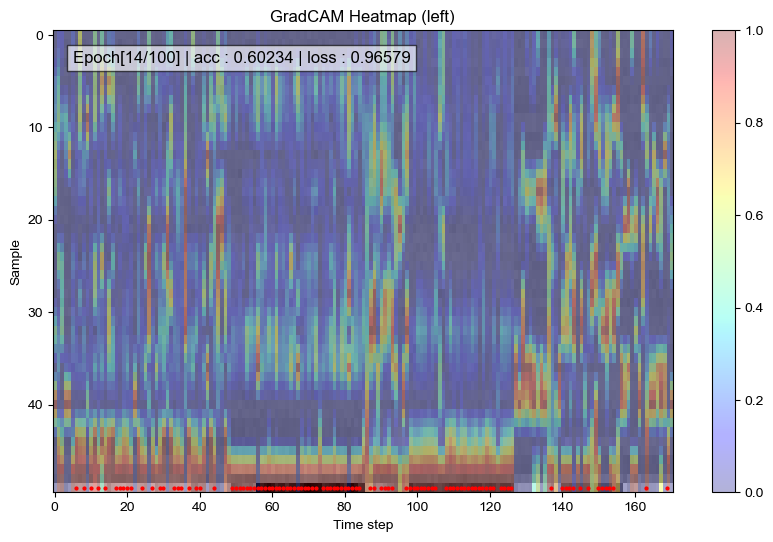

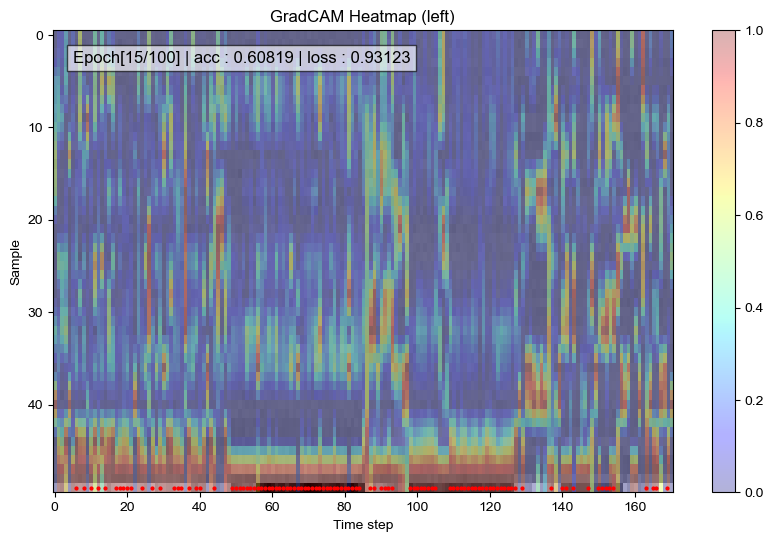

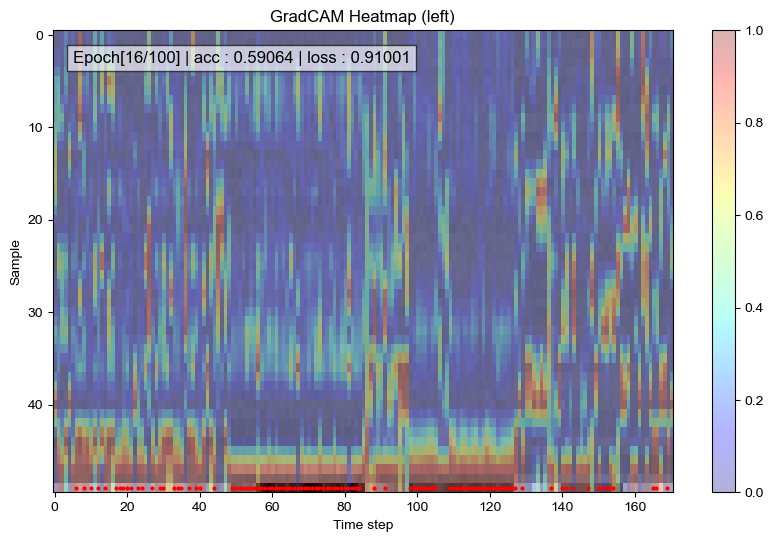

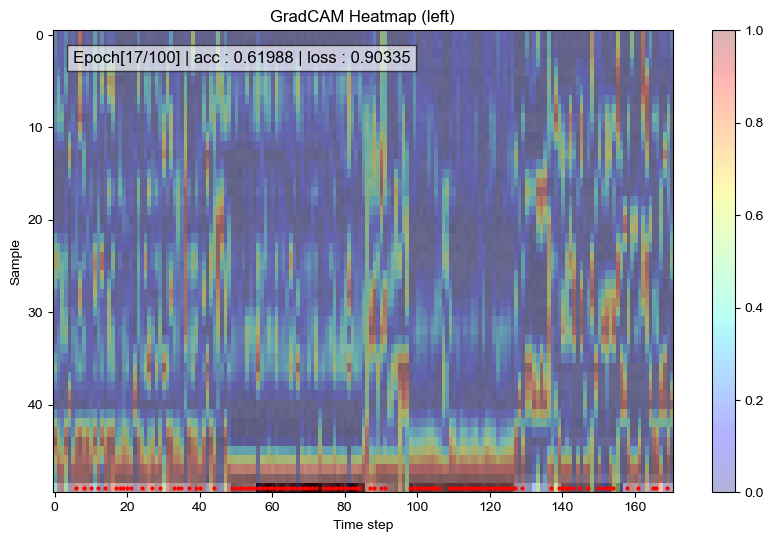

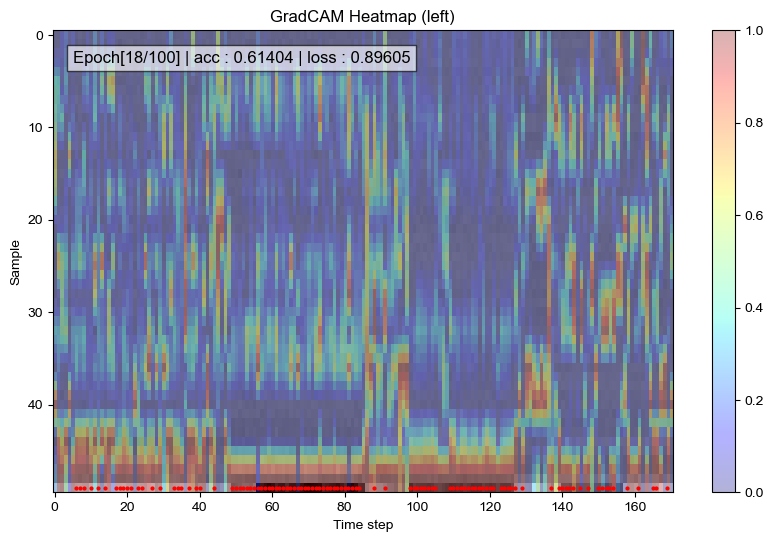

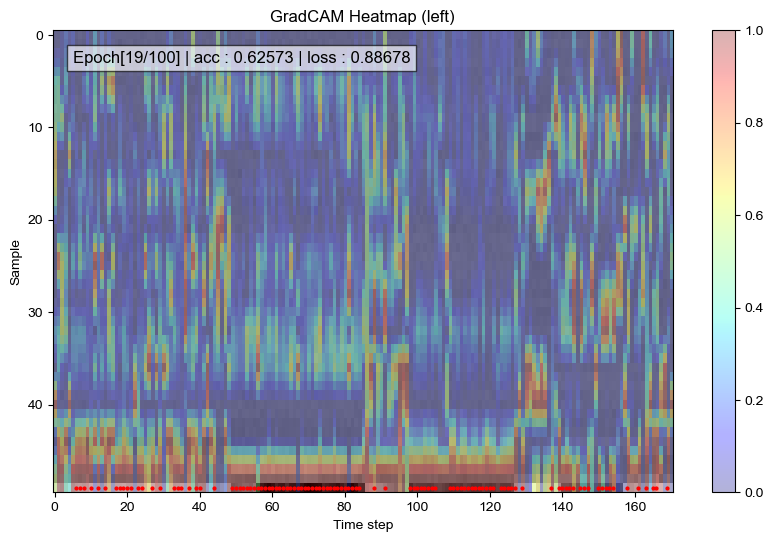

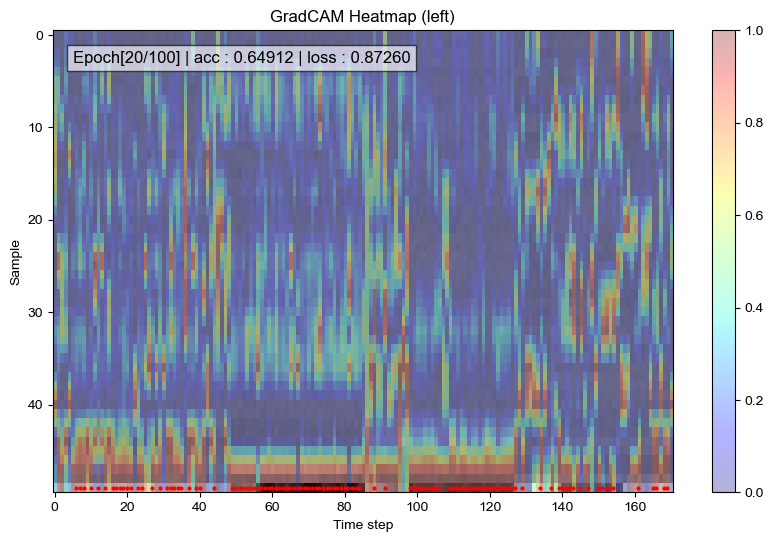

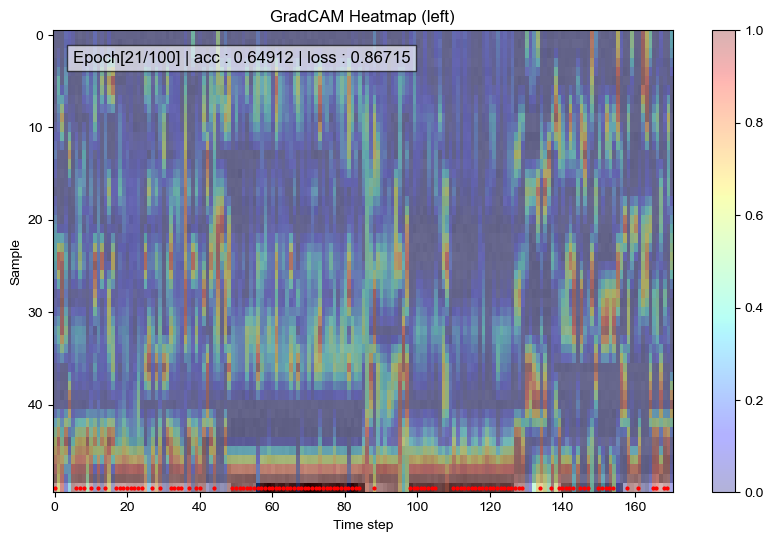

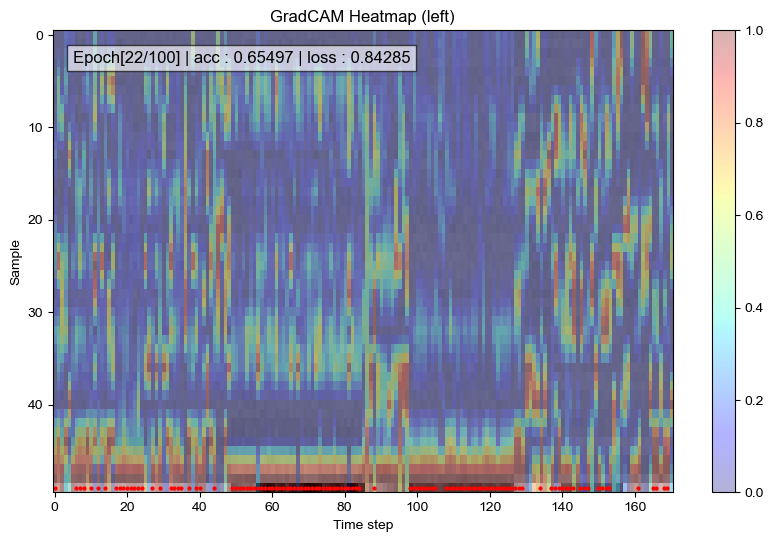

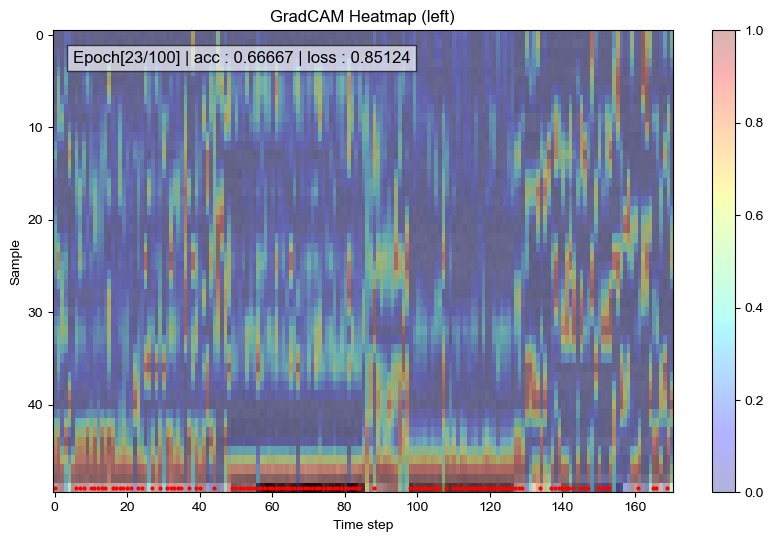

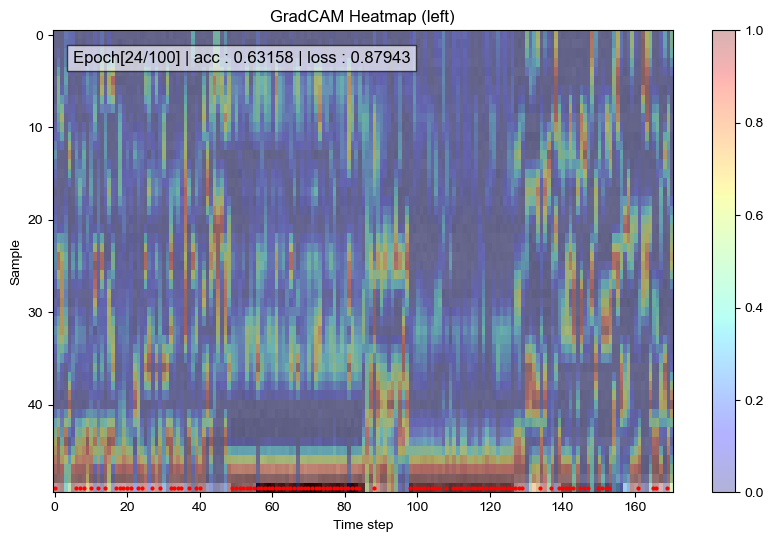

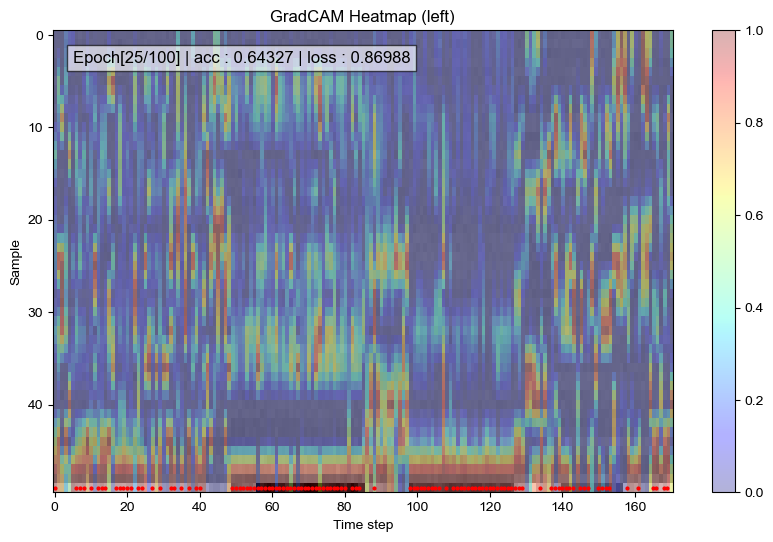

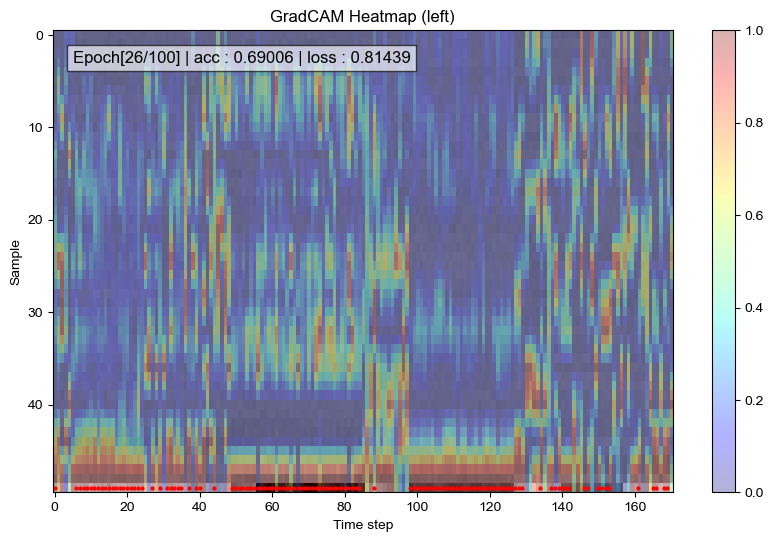

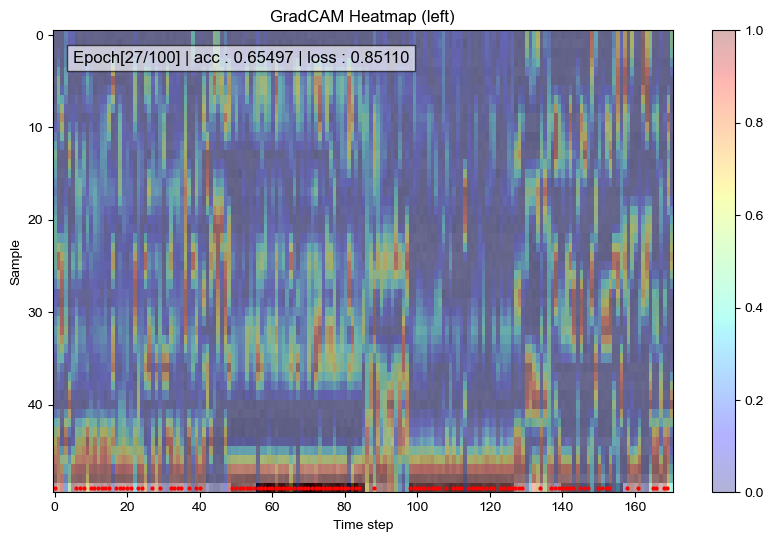

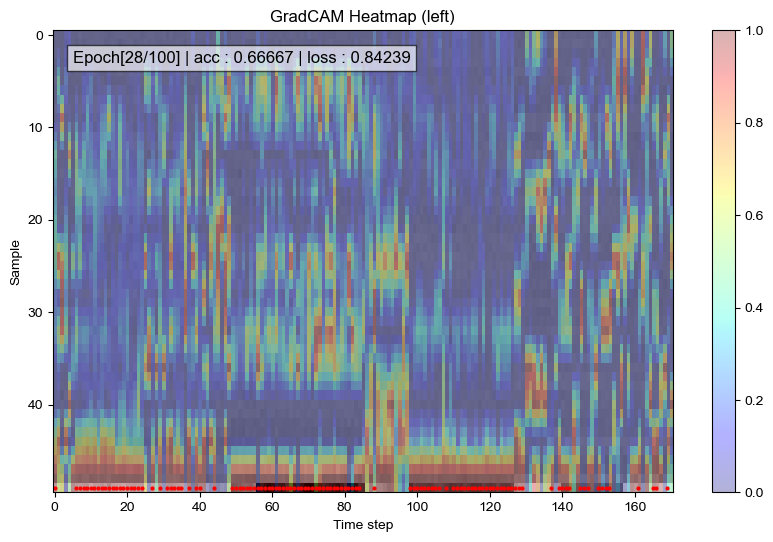

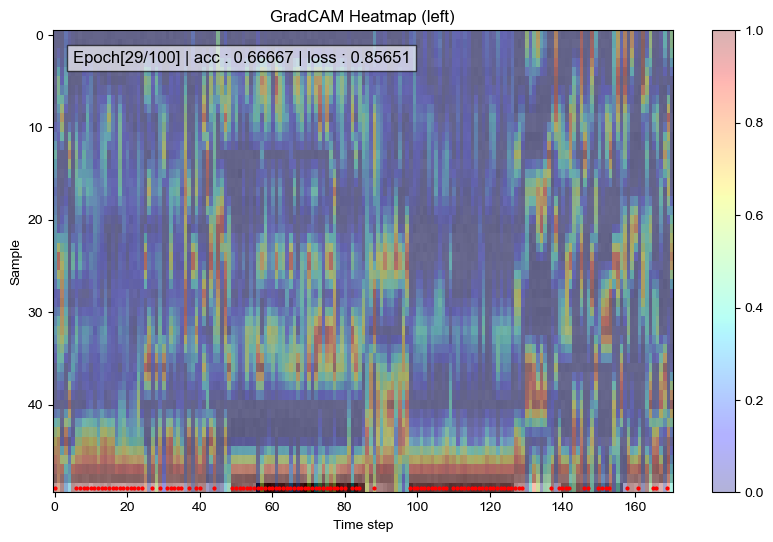

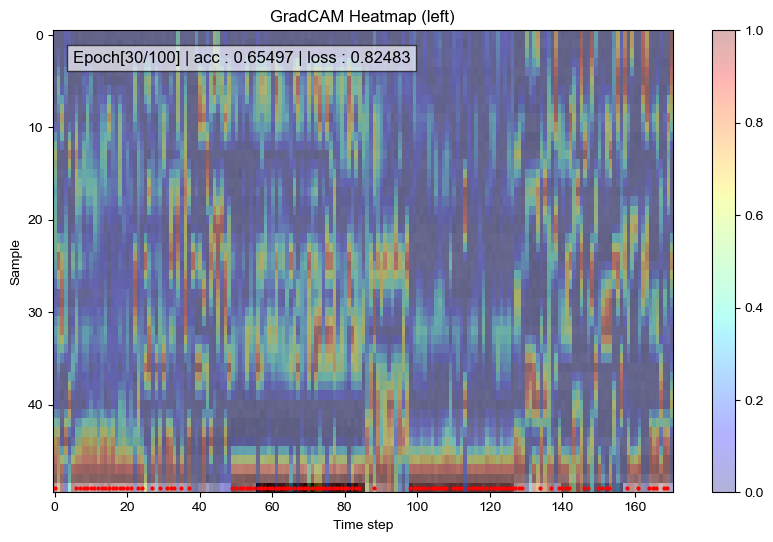

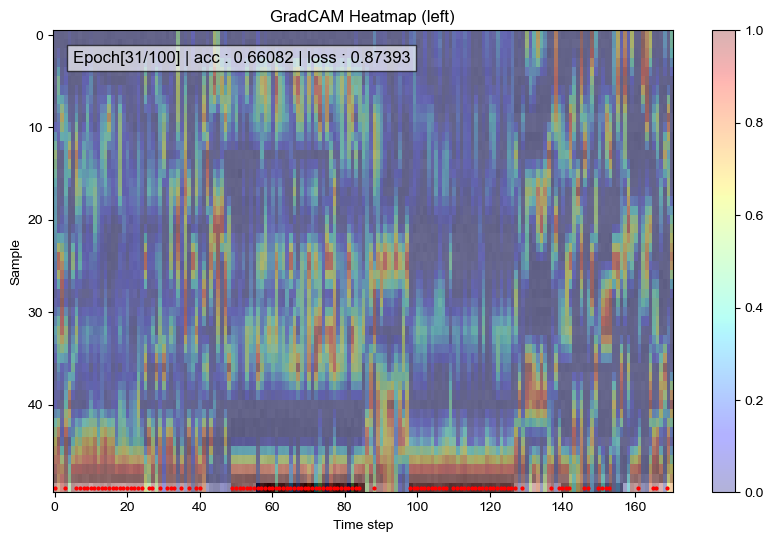

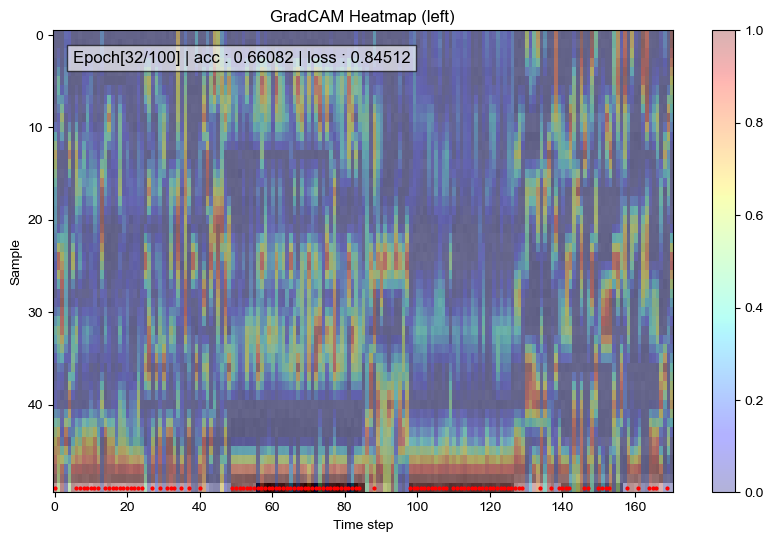

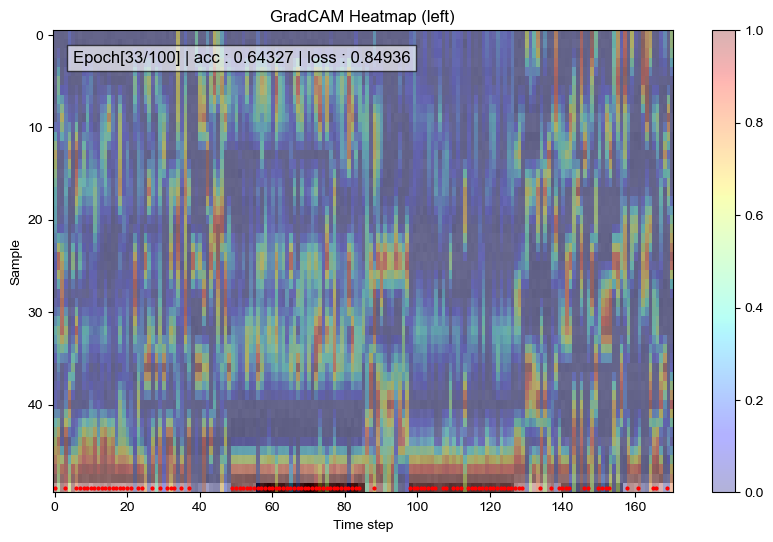

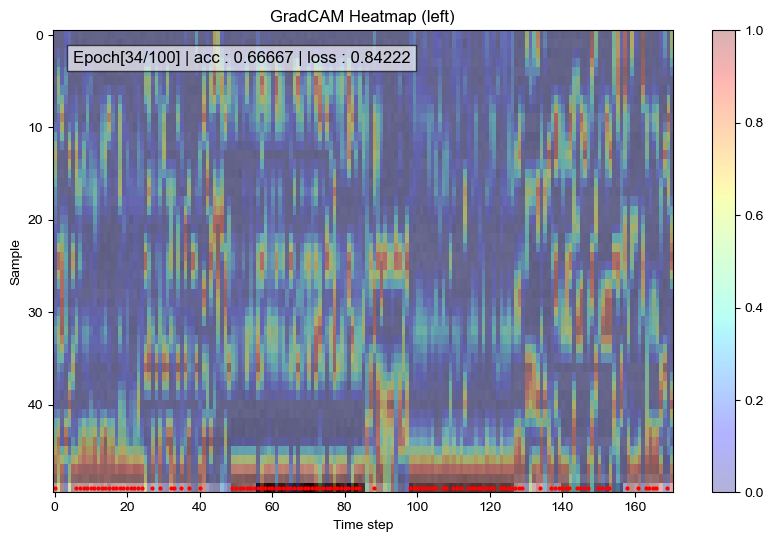

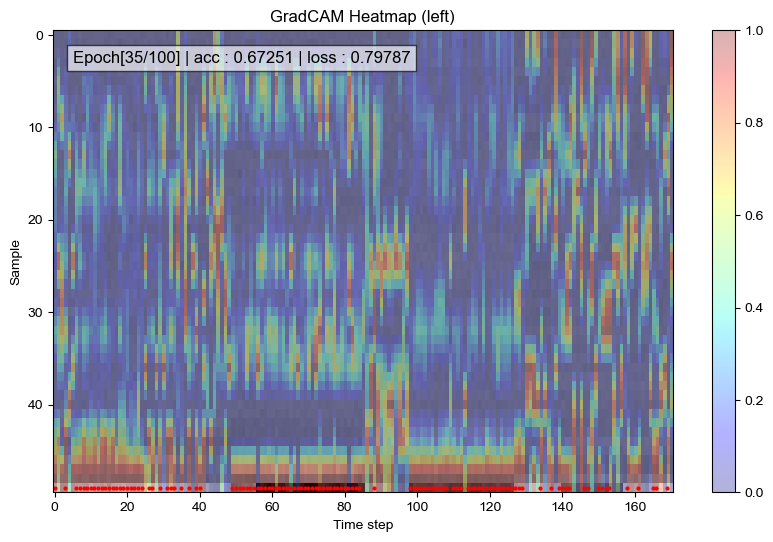

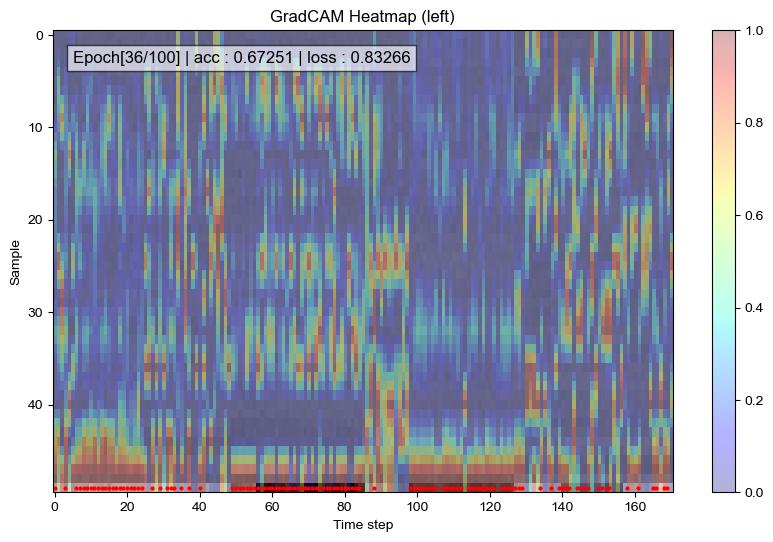

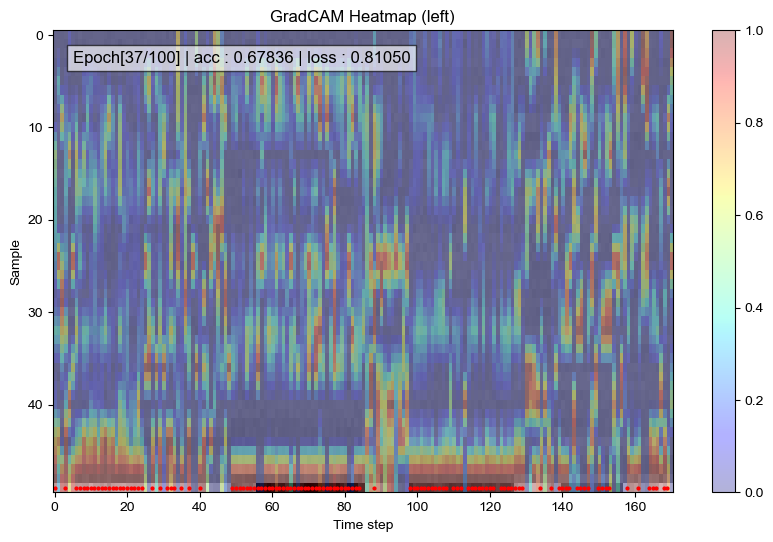

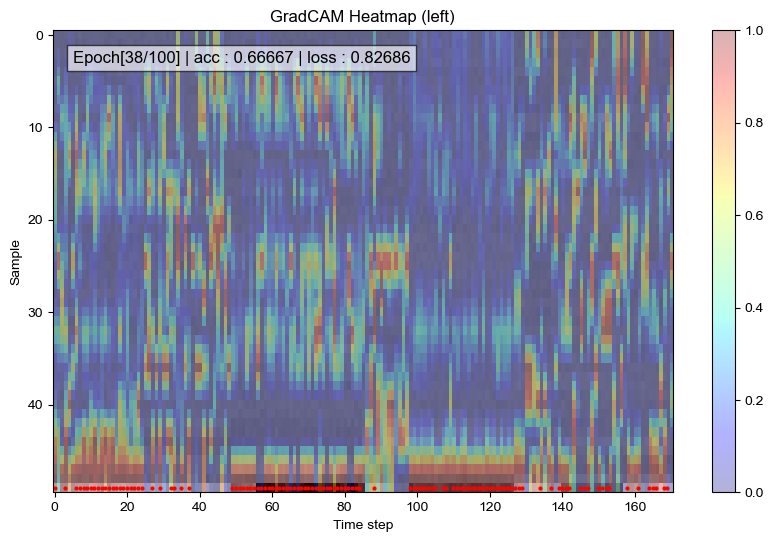

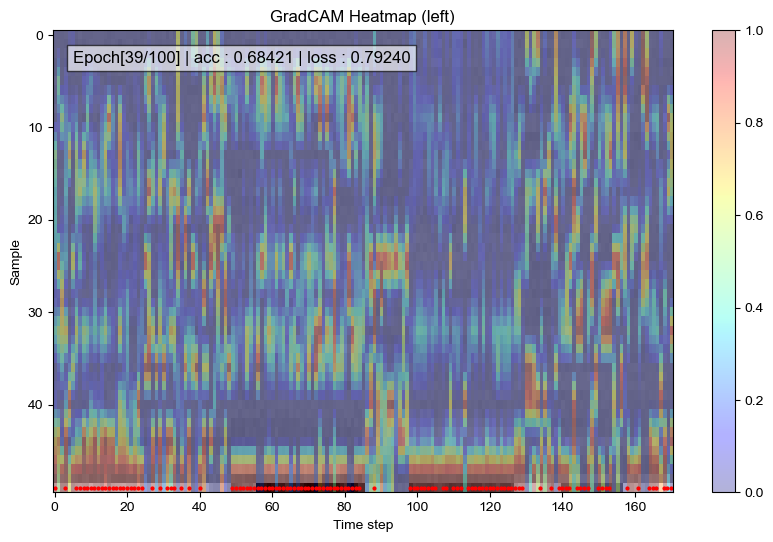

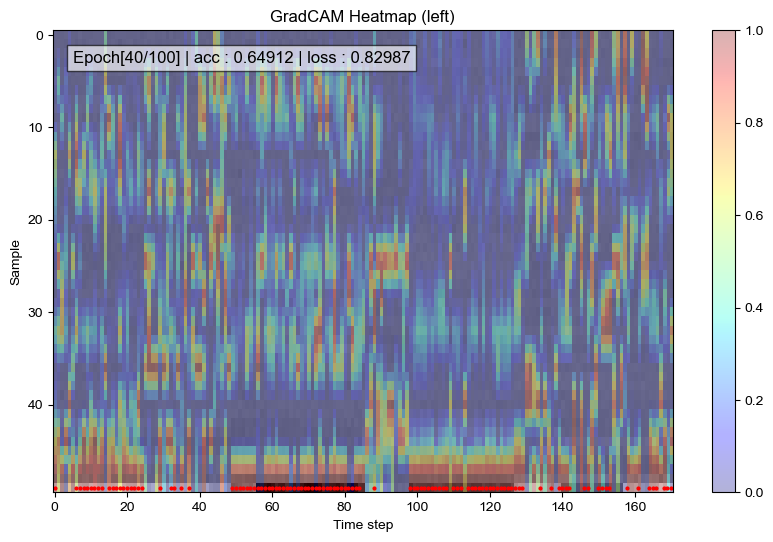

In [24]:
import copy
import torch.optim as optim
import torch.nn as nn
import model.har as har
import model.sehar as sehar
from torcheval.metrics import MulticlassConfusionMatrix

# モデルのインスタンス化
num_channel = 1
if not concat:
    num_channel = 2
net = har.HAR_resnet18(num_classes=4, num_channel=num_channel).to(device)
# net = sehar.SE_HAR(num_classes=4, num_channel=num_channel).to(device)
model = copy.deepcopy(net)

# 誤差関数を交差エントロピーで計算
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズム
lr = 1e-4
optimizer = optim.Adam(net.parameters(), lr=lr)

confusion_mat = MulticlassConfusionMatrix(
        num_classes = 4
)

train_accuracy, val_accuracy, test_accuracy = [], [], []
train_error, val_error, test_error = [], [], []
minimum_val_loss = 1e+100
early_stopping_count = 0
total_epoch = 0

# 学習
n_epoch = 100
for epoch in range(n_epoch):
    # 精度と損失の初期化
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_val = 0, 0
    test_loss, test_acc = 0, 0
    n_test = 0
    early_stopping_count += 1
    total_epoch += 1

    # 学習
    for train_input, train_label in train_loader:
        n_train += len(train_label)

        # 入力と正解ラベルをGPU上に移動
        input = train_input.to(device)
        label = train_label.to(device)
        # print(f'input : {input.shape}, label : {label.shape}')

        # モデルを学習モードに変更
        net.train()

        optimizer.zero_grad()
        output = net(input)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        predicted = torch.max(output, 1)[1]

        train_loss += loss.item()
        train_acc += (predicted == label).sum().item()

    # 検証
    for val_input, val_label in val_loader:
        n_val += len(val_label)

        val_input = val_input.to(device)
        val_label = val_label.to(device)

        # モデルを推論モードに変更
        net.eval()

        with torch.no_grad():
            val_output = net(val_input)
        loss = criterion(val_output, val_label)

        val_predicted = torch.max(val_output, 1)[1]
        
        val_loss += loss.item()
        val_acc += (val_predicted == val_label).sum().item()
        if epoch+1 == n_epoch:
            confusion_mat.update(val_predicted, val_label)

    # テスト
    TorF_flag = []
    for test_input, test_label in test_loader:
        n_test += len(test_label)

        test_input = test_input.to(device)
        test_label = test_label.to(device)

        # モデルを推論モードに変更
        net.eval()

        with torch.no_grad():
            test_output = net(test_input)
        loss = criterion(test_output, test_label)

        test_predicted = torch.max(test_output, 1)[1]

        test_loss += loss.item()
        test_acc += (test_predicted==test_label).sum().item()
        TorF_flag.append(1 if test_label==test_predicted else 0)
        
    # 精度を確率に変換
    test_acc /= n_test
    test_loss = test_loss / n_test

    print(f"loss : {test_loss:.5f}, acc : {test_acc:.5f}")

    # 精度を確率に変換
    train_acc /= n_train
    val_acc /= n_val
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_val

    # lossが最小の箇所のモデルを保存
    if val_loss < minimum_val_loss:
        minimum_val_loss = val_loss
        model = copy.deepcopy(net)
        early_stopping_count = 0

    train_accuracy.append(train_acc*100)
    val_accuracy.append(val_acc*100)
    test_accuracy.append(test_acc*100)
    train_error.append(train_loss)
    val_error.append(val_loss)
    test_error.append(test_loss)

    print(f"Epoch[{epoch+1}/{n_epoch}] | train_loss: {train_loss:.5f} | train_acc: {train_acc:.5f} | val_loss: {val_loss:.5f} | val_acc: {val_acc:.5f}")

    # Grad-CAM
    if epoch%1 == 0:
        gc = gradcam.GradCAM1D(net, target_layer=net.layer1b)
        visualize_gradcam(gc, 
                          TorF_flag,
                          show=False, 
                          save_path=f"{gif_dir}//{epoch}.png", 
                          msg=f"Epoch[{epoch+1}/{n_epoch}] | acc : {test_acc:.5f} | loss : {test_loss:.5f}"
                          )

    # 最小lossの更新が当分なければbreak
    if early_stopping_count >= 20:
        break

ru.make_gif(gif_dir, 'grad_cam.gif')


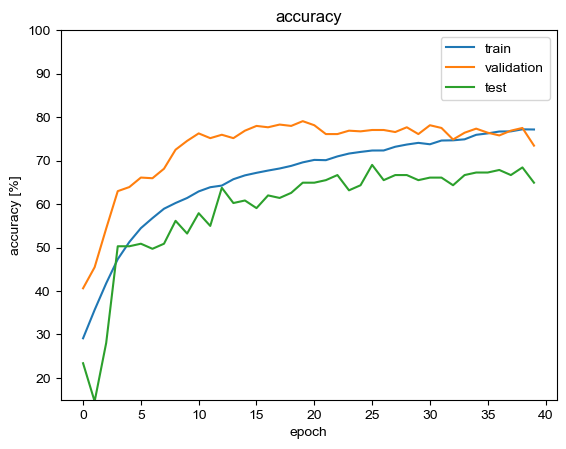

In [25]:
import matplotlib.pyplot as plt

x = np.arange(total_epoch)
plt.plot(x, train_accuracy, label="train")
plt.plot(x, val_accuracy, label="validation")
plt.plot(x, test_accuracy, label="test")

# グラフのタイトルと軸ラベルの作成
plt.ylim(15, 100)
plt.title("accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy [%]")
plt.legend()
plt.savefig("../images/accuracy.jpg")

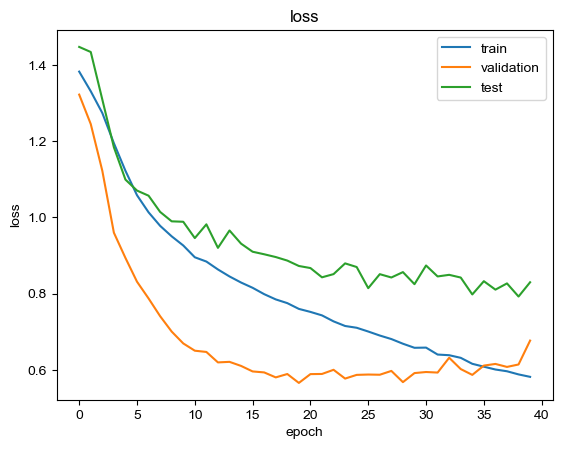

In [26]:
x = np.arange(total_epoch)
plt.plot(x, train_error, label="train")
plt.plot(x, val_error, label="validation")
plt.plot(x, test_error, label="test")

# グラフのタイトルと軸ラベルの作成
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig("../images/loss.jpg")

# 推定

loss : 1.16121, acc : 0.64912, recall : 0.64912, precision : 0.64912, f1_score : 0.64912
tensor([[25.,  4.,  3., 17.],
        [ 0., 36.,  1.,  0.],
        [12.,  0., 29.,  0.],
        [ 3., 16.,  4., 21.]])


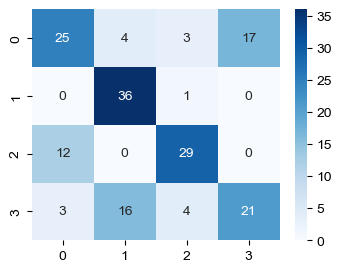

In [27]:
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics import MulticlassRecall
from torcheval.metrics import MulticlassPrecision
from torcheval.metrics import MulticlassF1Score
from torcheval.metrics import MulticlassConfusionMatrix

accuracy = MulticlassAccuracy(
        average = "micro",
        num_classes = 4
)
recall = MulticlassRecall(
        average = "micro",
        num_classes = 4
)
precision = MulticlassPrecision(
        average = "micro",
        num_classes = 4
)
f1_score = MulticlassF1Score(
        average = "micro",
        num_classes = 4 
)
confusion_mat = MulticlassConfusionMatrix(
        num_classes = 4
)
loss = 0
n = 0
TorF_flag = []

for input, label in test_loader:
        n += len(test_label)

        input = input.to(device)
        label = label.to(device)

        output = model(input)
        test_loss = criterion(output, label)

        predicted = torch.max(output, 1)[1]
        TorF_flag.append(1 if label==predicted else 0)

        loss += test_loss.item()
        accuracy.update(predicted, label)
        recall.update(predicted, label)
        precision.update(predicted, label)
        f1_score.update(predicted, label)
        confusion_mat.update(predicted, label)

# 精度を確率に変換
acc = accuracy.compute().item()
recall = recall.compute().item()
precision = precision.compute().item()
f1_score = f1_score.compute().item()
confusion_mat = confusion_mat.compute()
test_loss = test_loss * batch_size / n_test

print(f"loss : {test_loss:.5f}, acc : {test_acc:.5f}, recall : {recall:.5f}, precision : {precision:.5f}, f1_score : {f1_score:.5f}")
print(confusion_mat)

import utills.record_utillities as ru
confusion_mat = confusion_mat.to('cpu').detach().numpy().copy()
ru.save_confusion_matrix(confusion_mat)

# Grad-CAM
検証データのlossが最小のepochにおけるCNNのGrad-CAM

GradCam_generated!!


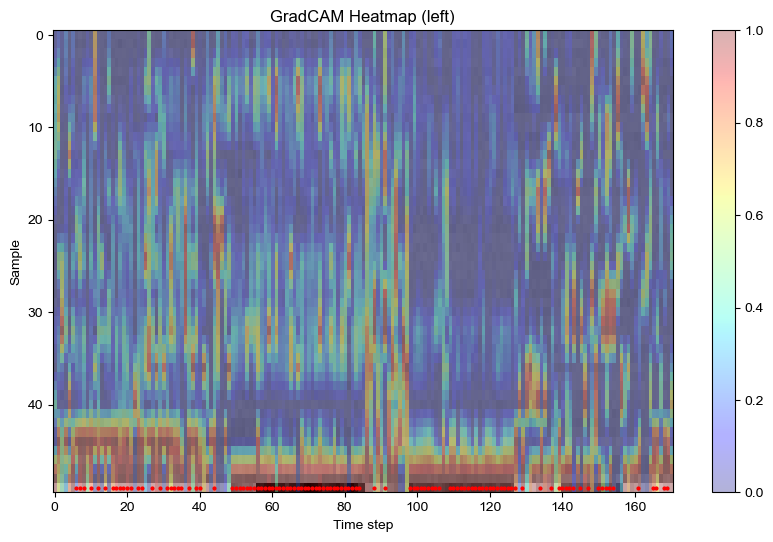

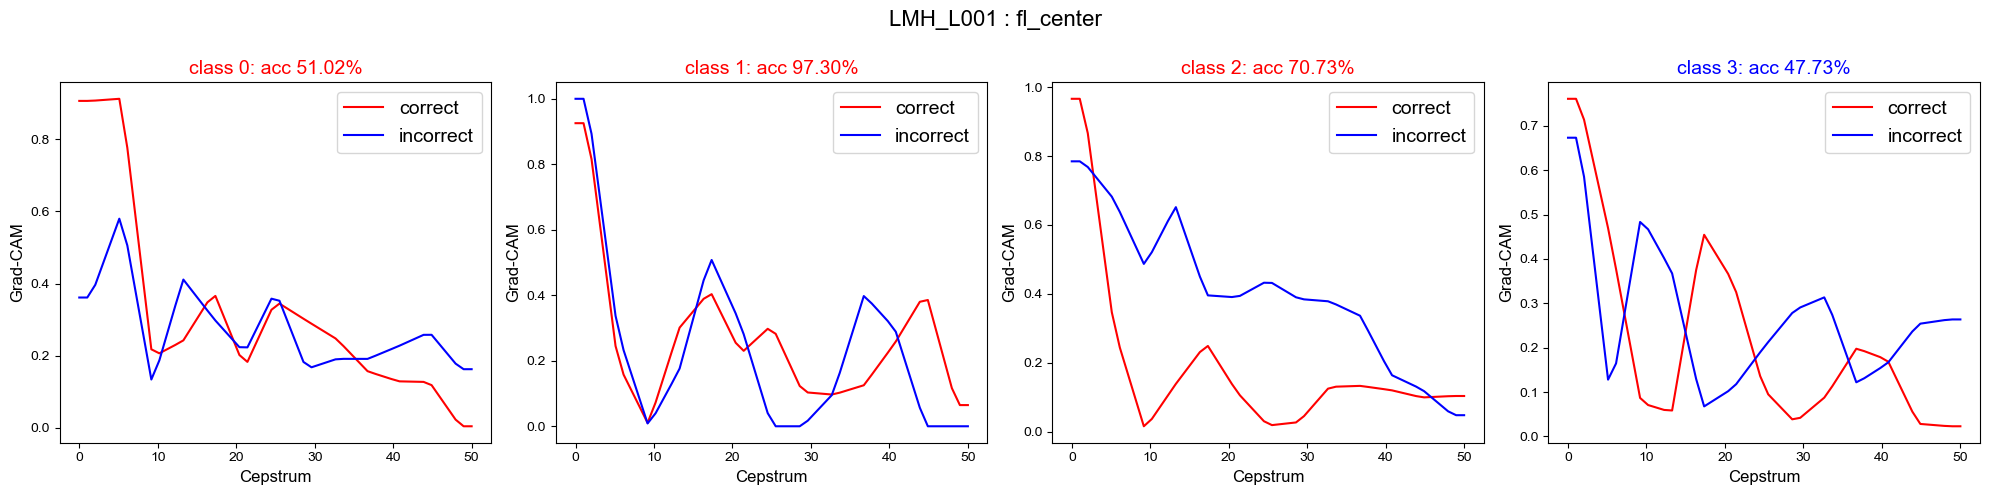

GradCam_generated!!


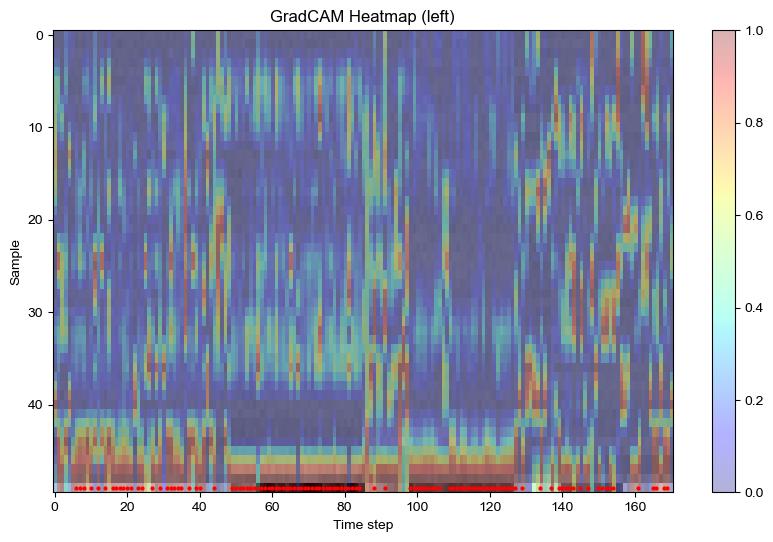

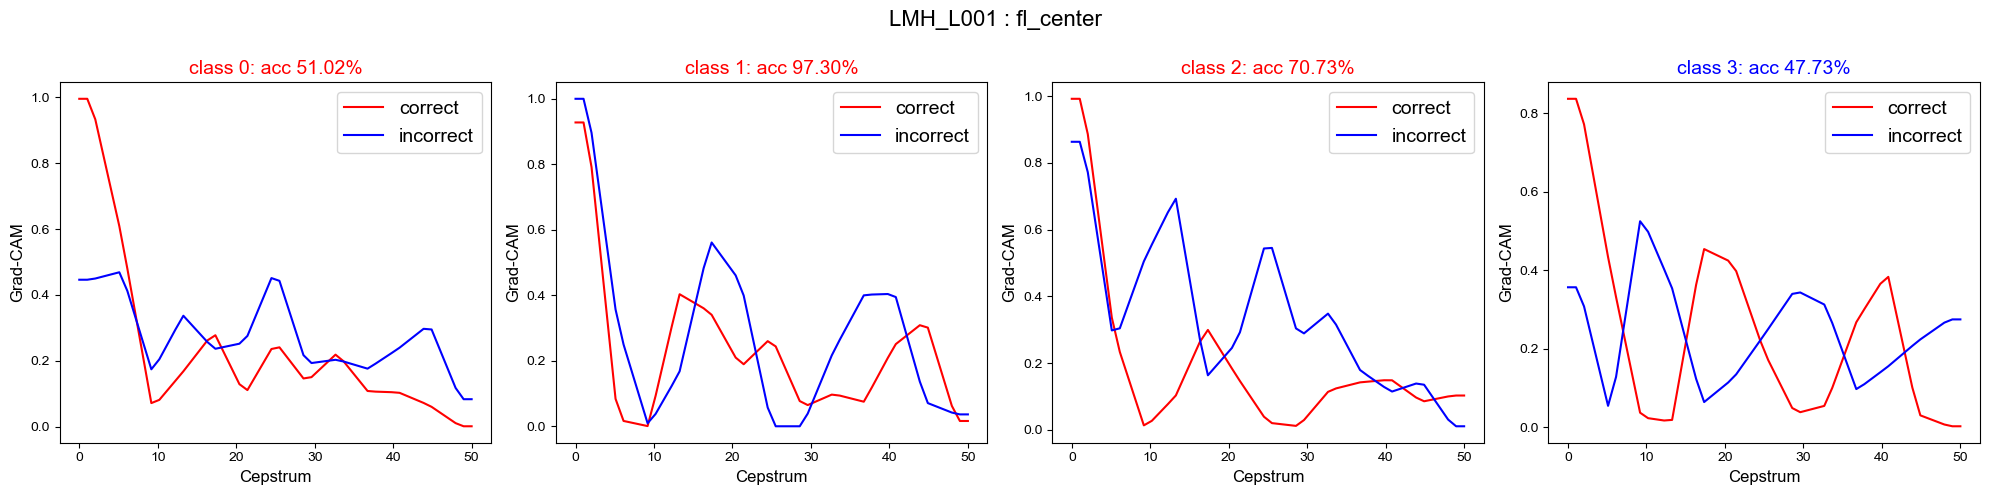

GradCam_generated!!


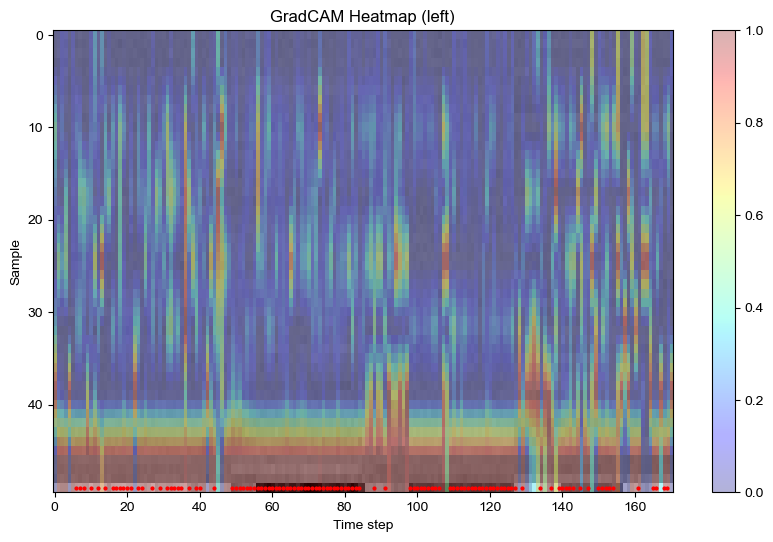

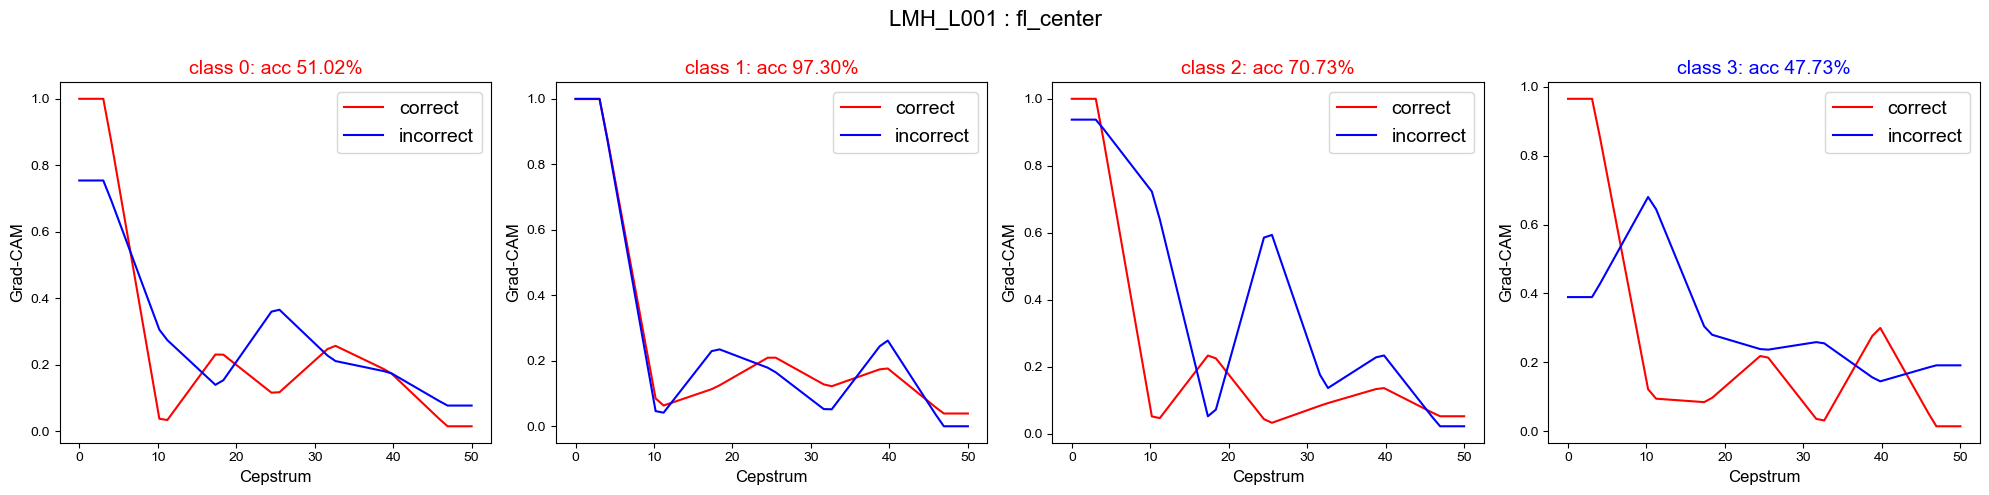

GradCam_generated!!


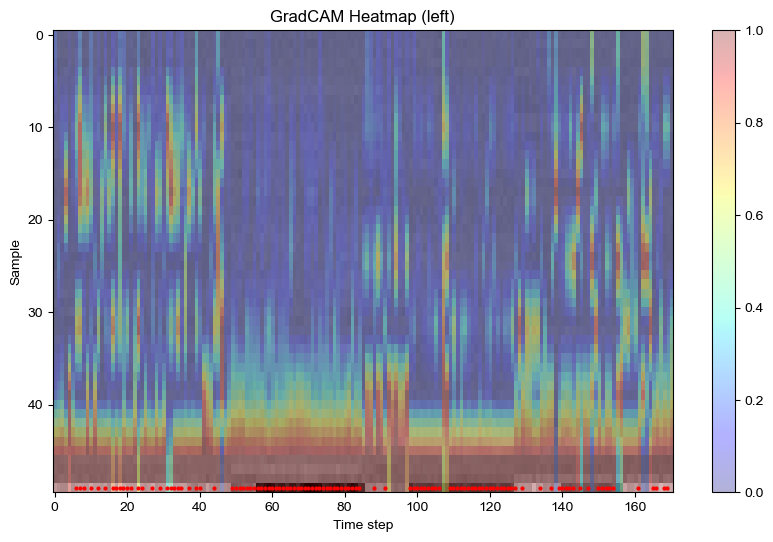

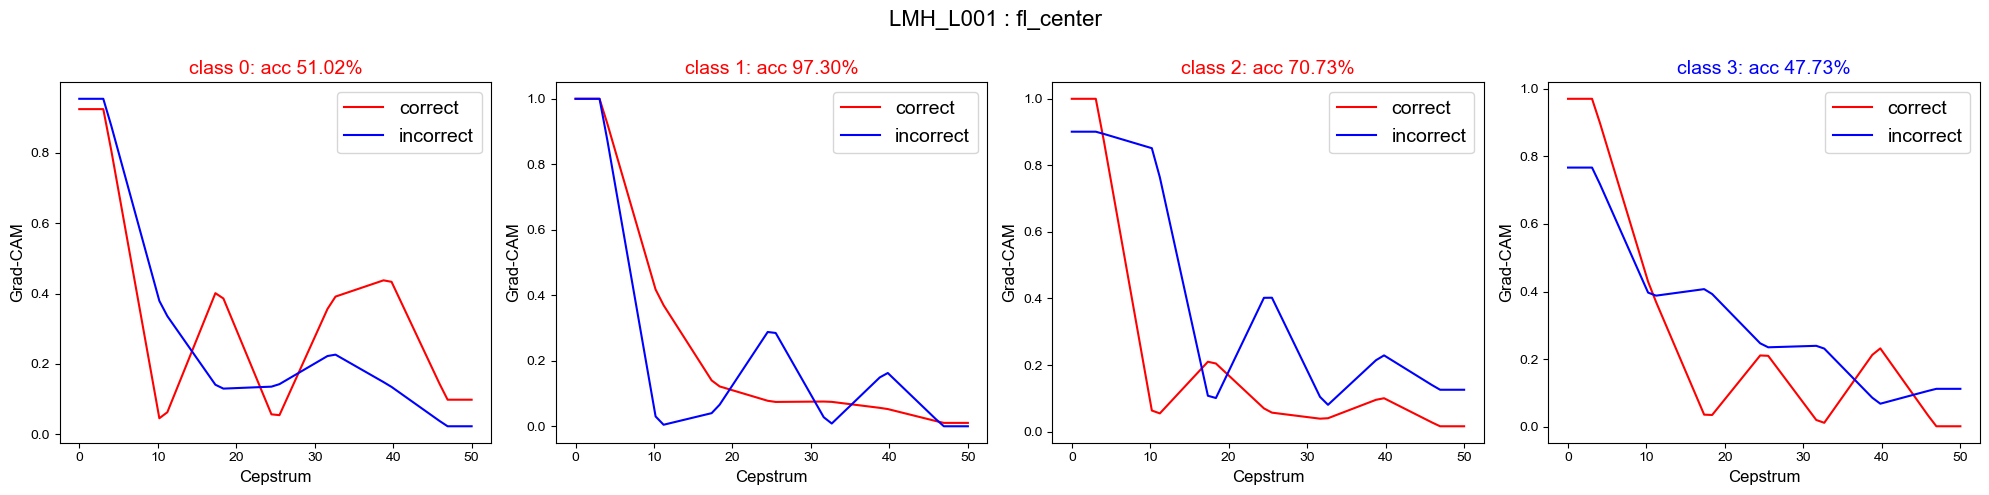

In [28]:
gc = gradcam.GradCAM1D(model, target_layer=model.layer1a)
visualize_gradcam(gc, TorF_flag, show=True)
visualize_gradcam2(gc, title=f"{train_type}_{train_tester} : {train_mattress}_{train_position}")

gc = gradcam.GradCAM1D(model, target_layer=model.layer1b)
visualize_gradcam(gc, TorF_flag, show=True)
visualize_gradcam2(gc, title=f"{train_type}_{train_tester} : {train_mattress}_{train_position}")

gc = gradcam.GradCAM1D(model, target_layer=model.layer2a)
visualize_gradcam(gc, TorF_flag, show=True)
visualize_gradcam2(gc, title=f"{train_type}_{train_tester} : {train_mattress}_{train_position}")

gc = gradcam.GradCAM1D(model, target_layer=model.layer2b)
visualize_gradcam(gc, TorF_flag, show=True)
visualize_gradcam2(gc, title=f"{train_type}_{train_tester} : {train_mattress}_{train_position}")